In [23]:
import pandas as pd
import joblib
import os
import numpy as np
import random
random.seed(5)
np.random.seed(5)

# Визуализация
import matplotlib.pyplot as plt

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Метрики
from sklearn.metrics import r2_score, mean_squared_error as MSE

# Создание пайплайна
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Масштабирование и кодирование признаков
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   PolynomialFeatures)

# Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

DATA_PATH = '../data'
MODEL_PATH = '../models/'

## Загрузка и подготовка данных

In [24]:
# Загрузим датасет.
# Зададим типы данных в колонках.
dtypes_of_data = {
            'car_make':'category',
            'car_model':'category',
            'car_gen':'category',
            'car_type':'category',
            'car_compl':'object',
            #'ann_date':datetime64[ns],
            'car_price':float,
            'ann_city':'category',
            'avail':'category',
            'year':int,
            'mileage':float,
            'color':'category',
            'eng_size':float,
            'eng_power':int,
            'eng_type':'category',
            'pow_resrv':int,
            'options':'object',
            'transmission':'category',
            'drive':'category',
            'st_wheel':'category',
            'count_owner':int,
            'original_pts':'category',
            'state_mark':'category',
            'class_auto':'category',
            'door_count':int,
            'long':int,
            'width':int,
           'height':int,
            'clearence':int,
            'v_tank':int,
            'curb_weight':int,
            'front_brakes':'category',
            'rear_brakes':'category',
            'max_speed':int,
            'acceleration':float,
            'fuel_cons':float,
            'fuel_brand':'category',
            'engine_loc1':'category',
            'engine_loc2':'category',
            'turbocharg':'category',
            'max_torq':int,
            'cyl_count':int,
            'seat_count':int,
            'v_bag_max':int,
            'acc_capacity':int,
            'age':int,
            'age_mod':float,
            'mileage_mod': float,
            'acceleration_mod': float,
            'cyl_count_mod': float            
        }
try:
    df = pd.read_csv(os.path.join(DATA_PATH, 'processed.csv'),
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
except:
    print('Changed directory for model to current directory')
    df = pd.read_csv('processed.csv',
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
print(df.shape)

(163864, 50)


In [25]:
# Уменьшим избыточную разрядность чисел
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns
df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

In [26]:
# Рассмотрим общие сведения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163864 entries, 0 to 163863
Data columns (total 50 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   car_make          163864 non-null  category      
 1   car_model         163864 non-null  category      
 2   car_gen           163864 non-null  category      
 3   car_type          163864 non-null  category      
 4   car_compl         163864 non-null  object        
 5   car_price         163864 non-null  float32       
 6   ann_city          163864 non-null  category      
 7   avail             163864 non-null  category      
 8   year              163864 non-null  int16         
 9   mileage           163864 non-null  float32       
 10  color             163864 non-null  category      
 11  eng_size          163864 non-null  float32       
 12  eng_power         163864 non-null  int16         
 13  eng_type          163864 non-null  category      
 14  pow_

## Модели на числовых признаках

In [27]:
# Список признаков
X = ['car_make', 'car_model', 'car_gen', 'car_type', 'car_compl',
       'ann_city', 'avail', 'year', 'mileage', 'color',
       'eng_size', 'eng_power', 'eng_type', 'pow_resrv', 'options',
       'transmission', 'drive', 'st_wheel', 'count_owner', 'original_pts',
       'state_mark', 'class_auto', 'door_count', 'long', 'width', 'height',
       'v_tank', 'curb_weight', 'front_brakes', 'rear_brakes', 'max_speed',
       'acceleration', 'fuel_cons', 'fuel_brand', 'engine_loc1', 'engine_loc2',
       'turbocharg', 'max_torq', 'cyl_count', 'seat_count', 'clearence',
       'v_bag', 'acc_capacity', 'age', 'age_mod', 'mileage_mod',
       'acceleration_mod', 'cyl_count_mod', 'ann_date']

# Целевая переменная
y = 'car_price'

In [47]:
# Составим список числовых признаков
num_features = (
    df[X].select_dtypes(
    include=['int8', 'int16', 'int32', 'float32', 'float64']
    ).columns.to_list()
)
num_features

['year',
 'mileage',
 'eng_size',
 'eng_power',
 'pow_resrv',
 'count_owner',
 'door_count',
 'long',
 'width',
 'height',
 'v_tank',
 'curb_weight',
 'max_speed',
 'acceleration',
 'fuel_cons',
 'max_torq',
 'cyl_count',
 'seat_count',
 'clearence',
 'v_bag',
 'acc_capacity',
 'age',
 'age_mod',
 'mileage_mod',
 'acceleration_mod',
 'cyl_count_mod']

In [29]:
# Составим список категориальных признаков
cat_features = df[X].select_dtypes(include=['category']).columns.to_list()
cat_features

['car_make',
 'car_model',
 'car_gen',
 'car_type',
 'ann_city',
 'avail',
 'color',
 'eng_type',
 'transmission',
 'drive',
 'st_wheel',
 'original_pts',
 'state_mark',
 'class_auto',
 'front_brakes',
 'rear_brakes',
 'fuel_brand',
 'engine_loc1',
 'engine_loc2',
 'turbocharg']

In [30]:
# Разобъём выборку
train, test = train_test_split(df, test_size=0.2)

In [31]:
y_train = train[y].copy()
X_train_num = train[num_features].copy()
y_test = test[y].copy()
X_test_num = test[num_features].copy()

In [32]:
# Проверим размерность
X_train_num.shape, y_train.shape

((131091, 26), (131091,))

In [33]:
# Проверим размерность
X_test_num.shape, y_test.shape

((32773, 26), (32773,))

In [34]:
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [13]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl.fit(X_train_num, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_pl.predict(X_train_num))}')
print(f'MSE {MSE(y_train, lr_pl.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_pl.predict(X_test_num))}')
print(f'MSE {MSE(y_test, lr_pl.predict(X_test_num))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_pl,
                    os.path.join(MODEL_PATH, 'lr_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl,
                    'lr_pl.pkl',
                    compress=0)

Обучающая выборка
R2 0.4199334383010864
MSE 18.165014266967773
Тестовая выборка
R2 0.49685168266296387
MSE 10.610675811767578


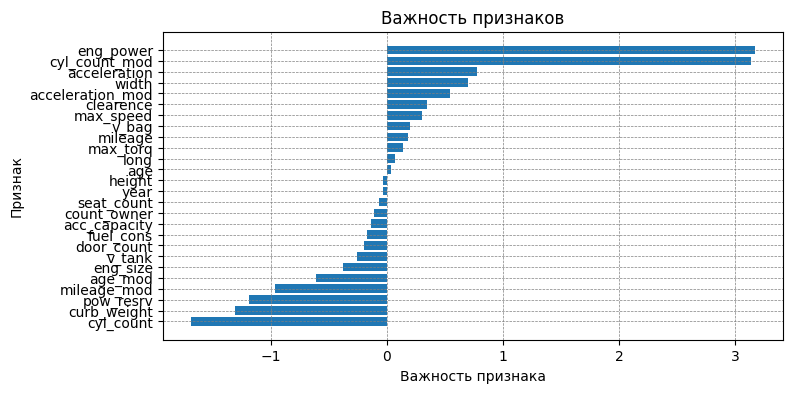

In [22]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = X_train_num.columns
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [23]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(1, 50000, 50)
}
gs_lasso_pl = GridSearchCV(
                           lasso_pl,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_lasso_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    'gs_lasso_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.32442446053028107
best_params: {'lasso__alpha': np.float64(1.0)}


In [24]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.32008618116378784
MSE 21.291772842407227
Тестовая выборка
R2 0.4079201817512512
MSE 12.486113548278809


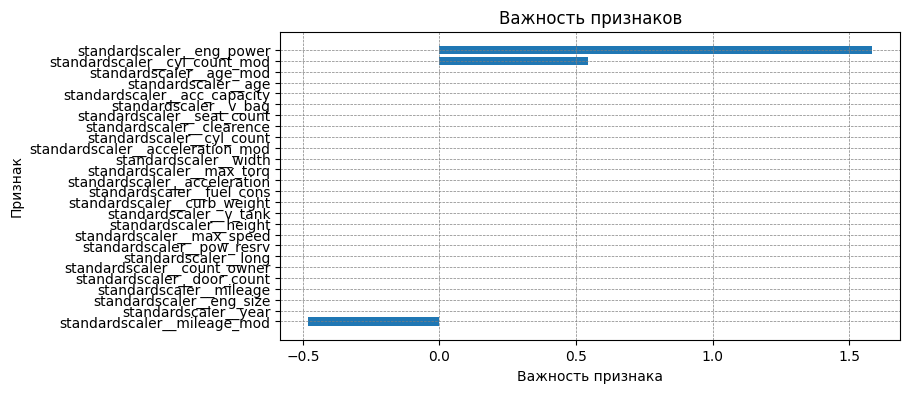

In [25]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [26]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(1, 50000, 50),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 20),
}
gs_elnet_pl = GridSearchCV(
                           elnet_pl,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    'gs_elnet_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
best_score: 0.3562881797552109
best_params: {'elasticnet__alpha': np.float64(1.0), 'elasticnet__l1_ratio': np.float64(0.01)}


In [27]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.351906955242157
MSE 20.2952938079834
Тестовая выборка
R2 0.44293612241744995
MSE 11.74767780303955


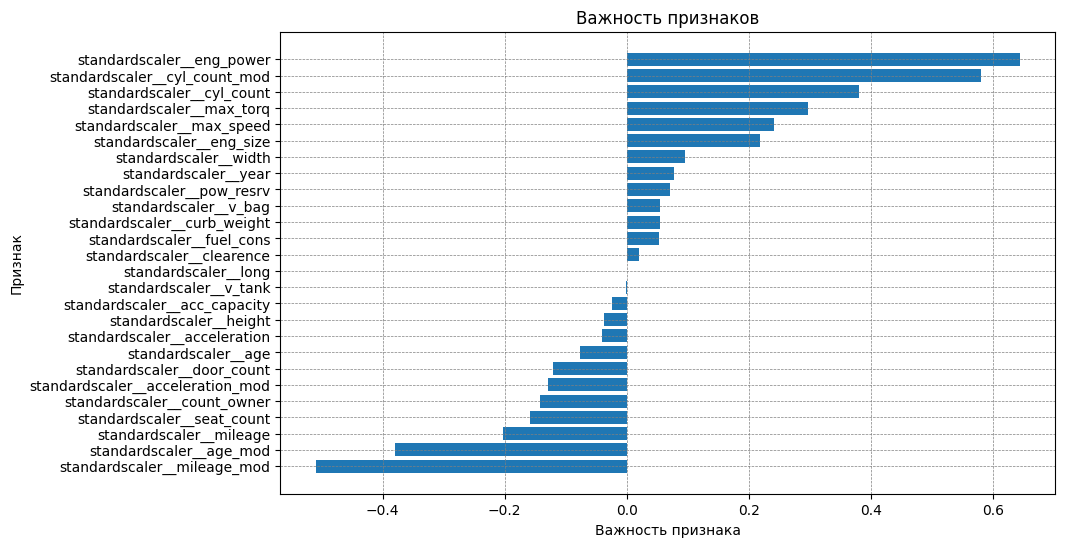

In [28]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [29]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 100)
}
gs_ridge_pl = GridSearchCV(
                           ridge_pl,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    'gs_ridge_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
best_score: 0.42157092690467834
best_params: {'ridge__alpha': np.float64(1.0)}


In [30]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_ridge_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_ridge_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_ridge_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_ridge_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.4200030565261841
MSE 18.1628360748291
Тестовая выборка
R2 0.49683308601379395
MSE 10.611067771911621


Качество моделей только на числовых признаках невысокое.

## Модели на всех признаках

In [35]:
X_train = train[cat_features + num_features]
X_test = test[cat_features + num_features]

In [14]:
# Обновим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore',
                      drop='first',
                      dtype='int16',
                      sparse_output=True),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [36]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl_ext = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl_ext.fit(X_train, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_pl_ext.predict(X_train))}')
print(f'MSE {MSE(y_train, lr_pl_ext.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_pl_ext.predict(X_test))}')
print(f'MSE {MSE(y_test, lr_pl_ext.predict(X_test))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_pl_ext,
                    os.path.join(MODEL_PATH, 'lr_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl_ext,
                    'lr_pl_ext.pkl',
                    compress=0)

Обучающая выборка
R2 0.9174765944480896
MSE 2.5842537879943848
Тестовая выборка
R2 0.8135755062103271


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 3.9314258098602295


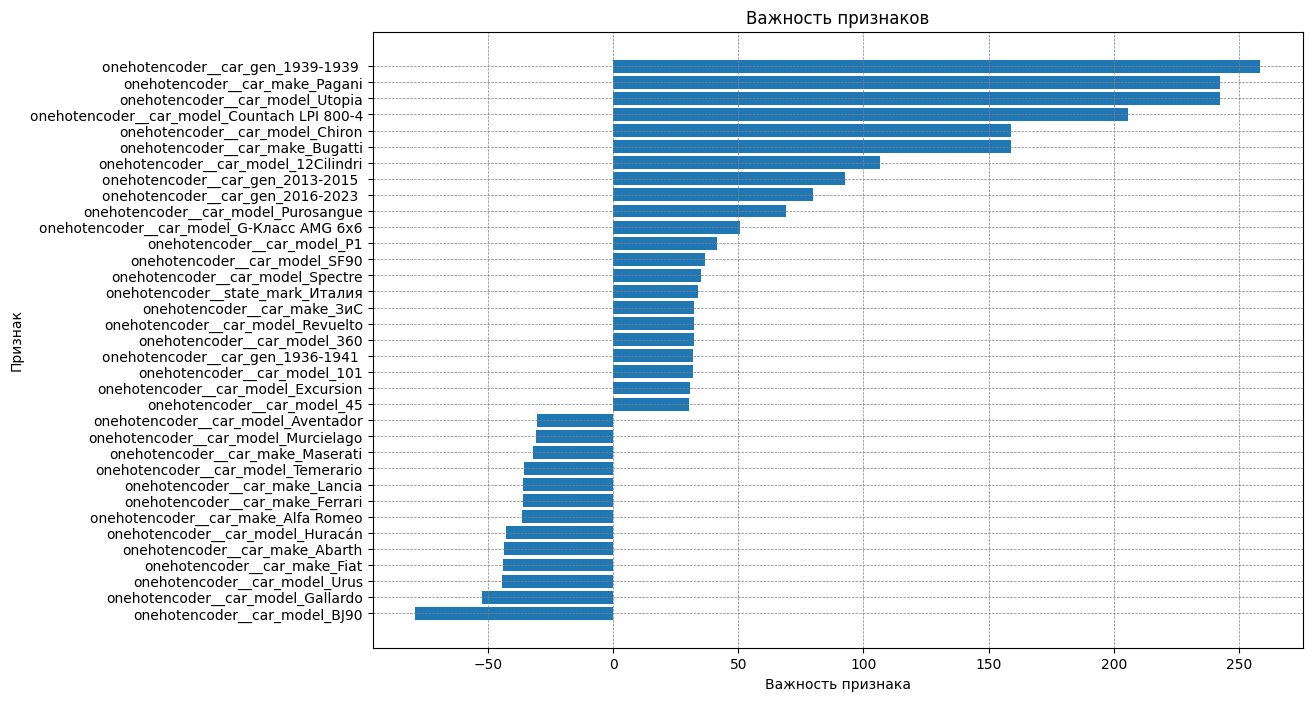

In [45]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl_ext.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = lr_pl_ext[:-1].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>30]
# Построим диаграмму для наглядности
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [46]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl_ext = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(1, 50000, 50)
}
gs_lasso_pl_ext = GridSearchCV(
                           lasso_pl_ext,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_lasso_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl_ext.best_estimator_,
                    'gs_lasso_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.32440902292728424
best_params: {'lasso__alpha': np.float64(1.0)}


In [47]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_lasso_pl_ext.best_estimator_.predict(X_train))}')
print(f'MSE {MSE(y_train, gs_lasso_pl_ext.best_estimator_.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_lasso_pl_ext.best_estimator_.predict(X_test))}')
print(f'MSE {MSE(y_test, gs_lasso_pl_ext.best_estimator_.predict(X_test))}')

Обучающая выборка
R2 0.3200753331184387
MSE 21.292112350463867
Тестовая выборка
R2 0.4079133868217468


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 12.486257553100586


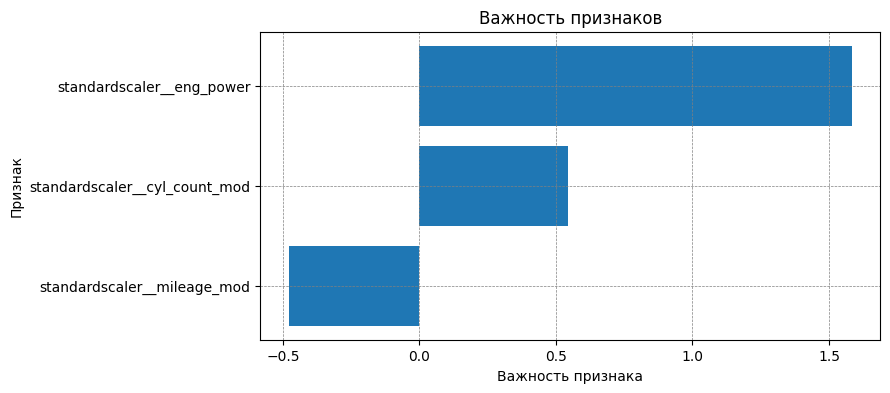

In [61]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl_ext.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl_ext.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [62]:
# Пайплайн обработки данных и обучения модели ElastiNet
elnet_pl_ext = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(1, 50000, 20),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 10),
}
gs_elnet_pl_ext = GridSearchCV(
                           elnet_pl_ext,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    'gs_elnet_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
best_score: 0.36108145117759705
best_params: {'elasticnet__alpha': np.float64(1.0), 'elasticnet__l1_ratio': np.float64(0.01)}


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1004.229248046875, tolerance: 410.5167541503906
  model = cd_fast.sparse_enet_coordinate_descent(


In [63]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_elnet_pl_ext.best_estimator_.predict(X_train))}')
print(f'MSE {MSE(y_train, gs_elnet_pl_ext.best_estimator_.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test))}')
print(f'MSE {MSE(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test))}')

Обучающая выборка
R2 0.3566615581512451
MSE 20.146400451660156
Тестовая выборка
R2 0.4495408535003662


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 11.608393669128418


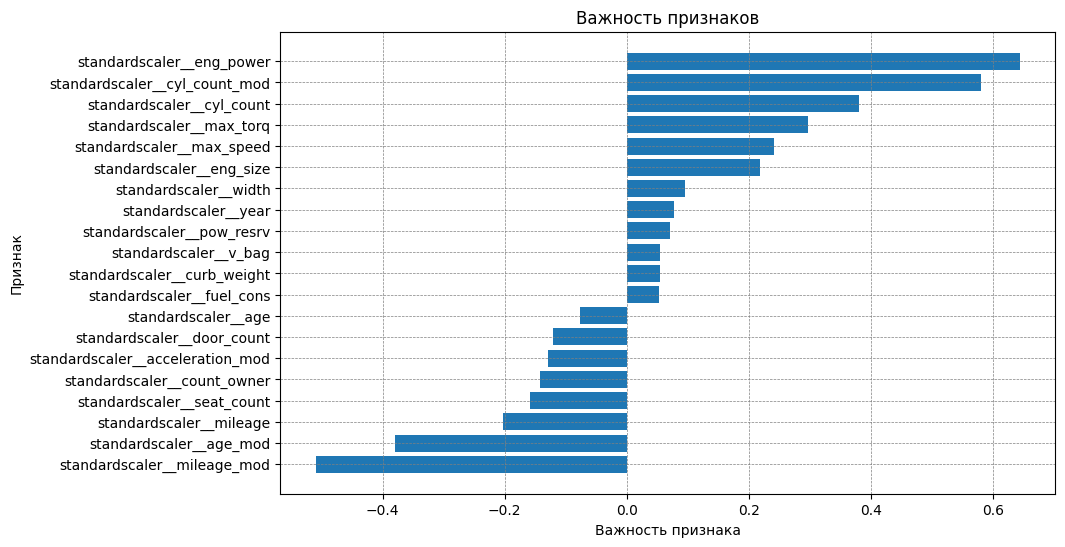

In [64]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [65]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_ext = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 50)
}
gs_ridge_pl_ext = GridSearchCV(
                           ridge_pl_ext,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    'gs_ridge_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.7960239201784134
best_params: {'ridge__alpha': np.float64(1.0)}


In [66]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_ridge_pl_ext.best_estimator_.predict(X_train))}')
print(f'MSE {MSE(y_train, gs_ridge_pl_ext.best_estimator_.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test))}')
print(f'MSE {MSE(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test))}')

Обучающая выборка
R2 0.8991859555244446
MSE 3.1570327281951904
Тестовая выборка
R2 0.8232532739639282


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 3.7273356914520264


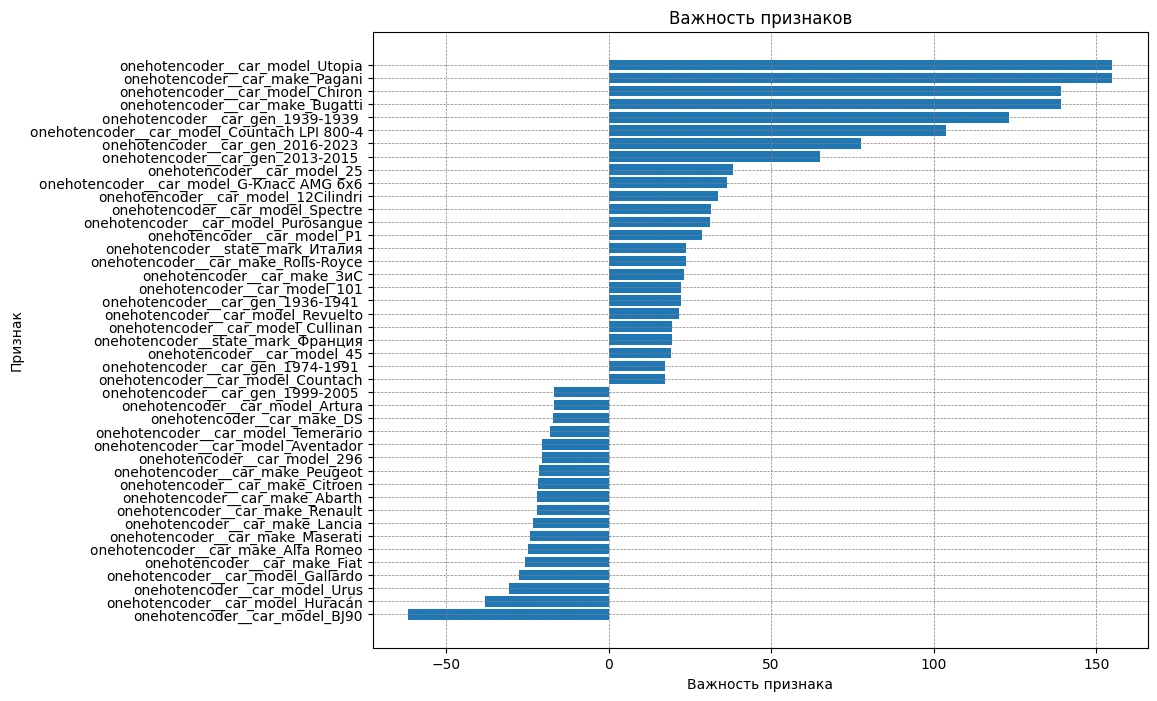

In [71]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_ext.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_ext.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>15]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

## Попробуем улучшить модель

Добавим полиномиальные признаки, уменьшим количество категорий категориальных признаков при OHE кодировании.

In [61]:
# Создадим преобразователь признаков
pf = PolynomialFeatures(degree = 2)

# Обучим и преобразуем обучающую выборку
X_poly = pf.fit_transform(X_train[num_features])
X_poly = pd.DataFrame(X_poly,
                      index = X_train.index,
                      columns = pf.get_feature_names_out())
X_train_poly = pd.concat([X_train, X_poly], axis=1).drop(columns=num_features)
X_train_poly.head()

,car_make,car_model,car_gen,car_type,ann_city,avail,color,eng_type,transmission,drive,...,age_mod^2,age_mod mileage_mod,age_mod acceleration_mod,age_mod cyl_count_mod,mileage_mod^2,mileage_mod acceleration_mod,mileage_mod cyl_count_mod,acceleration_mod^2,acceleration_mod cyl_count_mod,cyl_count_mod^2
143864,Lada (ВАЗ),Kalina,II,Универсал 5 дв.,Уфа,В наличии,коричневый,Бензин,механическая,передний,...,3.162278,3.150260,6.082652,1.422624,3.138289,6.059536,1.417217,11.700000,2.736421,0.64
73360,Skoda,Octavia,I Рестайлинг,Лифтбек,Москва,В наличии,серебристый,Бензин,механическая,передний,...,3.741657,3.837589,6.644664,1.547469,3.935979,6.815024,1.587144,11.799999,2.748090,0.64
160269,Mitsubishi,Lancer,IX,Седан,Москва,В наличии,серебристый,Бензин,механическая,передний,...,4.472136,4.472136,7.264379,1.691794,4.472136,7.264379,1.691794,11.799999,2.748090,0.64
125372,Lada (ВАЗ),2121 (4x4),I Рестайлинг,Внедорожник 3 дв.,Ревда,В наличии,синий,Бензин,механическая,полный,...,4.123105,3.949858,7.570414,1.624434,3.783890,7.252315,1.556178,13.900000,2.982616,0.64
83692,Toyota,RAV4,IV,Внедорожник 5 дв.,Воронеж,В наличии,белый,Дизель,автоматическая,полный,...,3.162278,3.575312,5.623414,1.422624,4.042293,6.357903,1.608436,10.000000,2.529822,0.64


In [62]:
# Преобразуем тестовую выборку
X_poly = pf.transform(X_test[num_features])
X_poly = pd.DataFrame(X_poly,
                      index = X_test.index,
                      columns = pf.get_feature_names_out())
X_test_poly = pd.concat([X_test, X_poly], axis=1).drop(columns=num_features)
X_test_poly.head()

,car_make,car_model,car_gen,car_type,ann_city,avail,color,eng_type,transmission,drive,...,age_mod^2,age_mod mileage_mod,age_mod acceleration_mod,age_mod cyl_count_mod,mileage_mod^2,mileage_mod acceleration_mod,mileage_mod cyl_count_mod,acceleration_mod^2,acceleration_mod cyl_count_mod,cyl_count_mod^2
17122,Citroen,C3,I,Хэтчбек 5 дв.,Ставрополь,В наличии,серый,Бензин,автоматическая,передний,...,4.472136,3.760603,8.897011,1.691794,3.162278,7.481464,1.422624,17.699999,3.365709,0.64
111617,Chevrolet,Aveo,I,Седан,Бахчисарай,В наличии,синий,Бензин,механическая,передний,...,4.358899,4.259205,7.783874,1.670238,4.161791,7.605846,1.632038,13.900000,2.982616,0.64
99419,Lada (ВАЗ),2109,1987-2006,Хэтчбек 5 дв.,Канск,В наличии,зелёный,Бензин,механическая,передний,...,5.000000,4.029068,8.336666,1.788854,3.246678,6.717799,1.441483,13.900000,2.982616,0.64
71567,SEAT,Cordoba,II Рестайлинг,Седан,Нерюнгри,В наличии,серый,Бензин,механическая,передний,...,4.123105,3.511547,6.548305,1.624434,2.990697,5.577029,1.383491,10.400000,2.579922,0.64
99672,Lada (ВАЗ),2111,1997-2014,Универсал 5 дв.,Можайск,В наличии,серебристый,Бензин,механическая,передний,...,4.472136,4.129287,7.884332,1.691794,3.812722,7.279892,1.562096,13.900000,2.982616,0.64


In [63]:
# Уменьшим избыточную разрядность чисел
fcols = X_train_poly.select_dtypes('float').columns
icols = X_train_poly.select_dtypes('integer').columns

X_train_poly[fcols] = X_train_poly[fcols].apply(pd.to_numeric, downcast='float')
X_train_poly[icols] = X_train_poly[icols].apply(pd.to_numeric, downcast='integer')
X_test_poly[fcols] = X_test_poly[fcols].apply(pd.to_numeric, downcast='float')
X_test_poly[icols] = X_test_poly[icols].apply(pd.to_numeric, downcast='integer')

In [64]:
# Составим список числовых признаков
num_features = (
    X_train_poly.select_dtypes(
    include=['int8', 'int16', 'int32', 'float32', 'float64']
    ).columns.to_list()
)
num_features

['1',
 'year^2',
 'year mileage',
 'year eng_size',
 'year eng_power',
 'year pow_resrv',
 'year count_owner',
 'year door_count',
 'year long',
 'year width',
 'year height',
 'year v_tank',
 'year curb_weight',
 'year max_speed',
 'year acceleration',
 'year fuel_cons',
 'year max_torq',
 'year cyl_count',
 'year seat_count',
 'year clearence',
 'year v_bag',
 'year acc_capacity',
 'year age',
 'year age_mod',
 'year mileage_mod',
 'year acceleration_mod',
 'year cyl_count_mod',
 'mileage^2',
 'mileage eng_size',
 'mileage eng_power',
 'mileage pow_resrv',
 'mileage count_owner',
 'mileage door_count',
 'mileage long',
 'mileage width',
 'mileage height',
 'mileage v_tank',
 'mileage curb_weight',
 'mileage max_speed',
 'mileage acceleration',
 'mileage fuel_cons',
 'mileage max_torq',
 'mileage cyl_count',
 'mileage seat_count',
 'mileage clearence',
 'mileage v_bag',
 'mileage acc_capacity',
 'mileage age',
 'mileage age_mod',
 'mileage mileage_mod',
 'mileage acceleration_mod',
 '

In [65]:
# Обновим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore',
                      drop='first',
                      dtype='int16',
                      min_frequency=5,
                      max_categories=150,
                      sparse_output=True),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [66]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl_poly = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl_poly.fit(X_train_poly, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_pl_poly.predict(X_train_poly))}')
print(f'MSE {MSE(y_train, lr_pl_poly.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_pl_poly.predict(X_test_poly))}')
print(f'MSE {MSE(y_test, lr_pl_poly.predict(X_test_poly))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_pl_poly,
                    os.path.join(MODEL_PATH, 'lr_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl_poly,
                    'lr_pl_poly.pkl',
                    compress=0)

Обучающая выборка
R2 0.769601583480835
MSE 7.215019702911377
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 0.8095684051513672
MSE 4.015928745269775


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


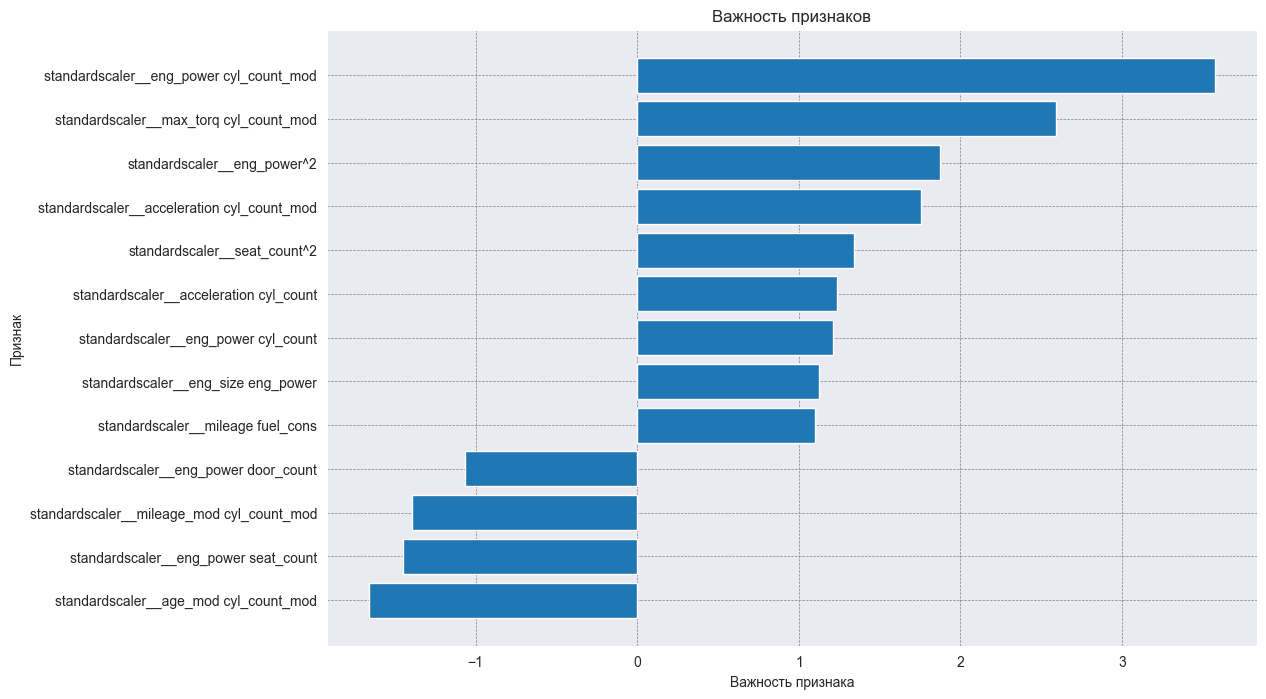

In [72]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl_poly.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = lr_pl_poly[:-1].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>1]
# Построим диаграмму для наглядности
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [75]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl_poly = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(1, 50000, 50)
}
gs_lasso_pl_poly = GridSearchCV(
                           lasso_pl_poly,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_lasso_pl_poly.fit(X_train_poly, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl_poly.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl_poly.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl_poly.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl_poly.best_estimator_,
                    'gs_lasso_pl_poly.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.48402850329875946
best_params: {'lasso__alpha': np.float64(1.0)}


In [76]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_lasso_pl_poly.best_estimator_.predict(X_train_poly))}')
print(f'MSE {MSE(y_train, gs_lasso_pl_poly.best_estimator_.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_lasso_pl_poly.best_estimator_.predict(X_test_poly))}')
print(f'MSE {MSE(y_test, gs_lasso_pl_poly.best_estimator_.predict(X_test_poly))}')

Обучающая выборка
R2 0.4811166524887085
MSE 16.249038696289062
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 0.5456808805465698
MSE 9.580938339233398


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


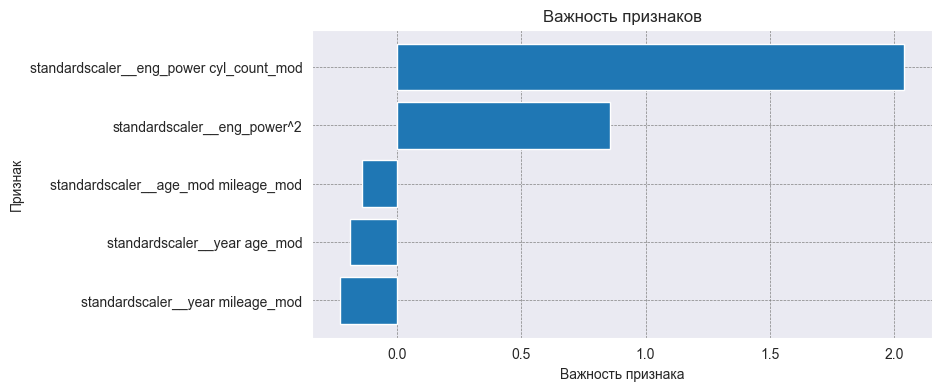

In [77]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl_poly.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl_poly.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [81]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl_poly = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(1, 50000, 20),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 10),
}
gs_elnet_pl_poly = GridSearchCV(
                           elnet_pl_poly,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_elnet_pl_poly.fit(X_train_poly, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_poly.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_poly.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_poly.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_poly.best_estimator_,
                    'gs_elnet_pl_poly.pkl',
                    compress=0)

best_score: 0.5990887582302094
best_params: {'elasticnet__alpha': np.float64(1.0), 'elasticnet__l1_ratio': np.float64(0.01)}


In [82]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_elnet_pl_poly.best_estimator_.predict(X_train_poly))}')
print(f'MSE {MSE(y_train, gs_elnet_pl_poly.best_estimator_.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_elnet_pl_poly.best_estimator_.predict(X_test_poly))}')
print(f'MSE {MSE(y_test, gs_elnet_pl_poly.best_estimator_.predict(X_test_poly))}')

Обучающая выборка
R2 0.5973150730133057
MSE 12.610238075256348
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 0.6884415149688721
MSE 6.570322036743164


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


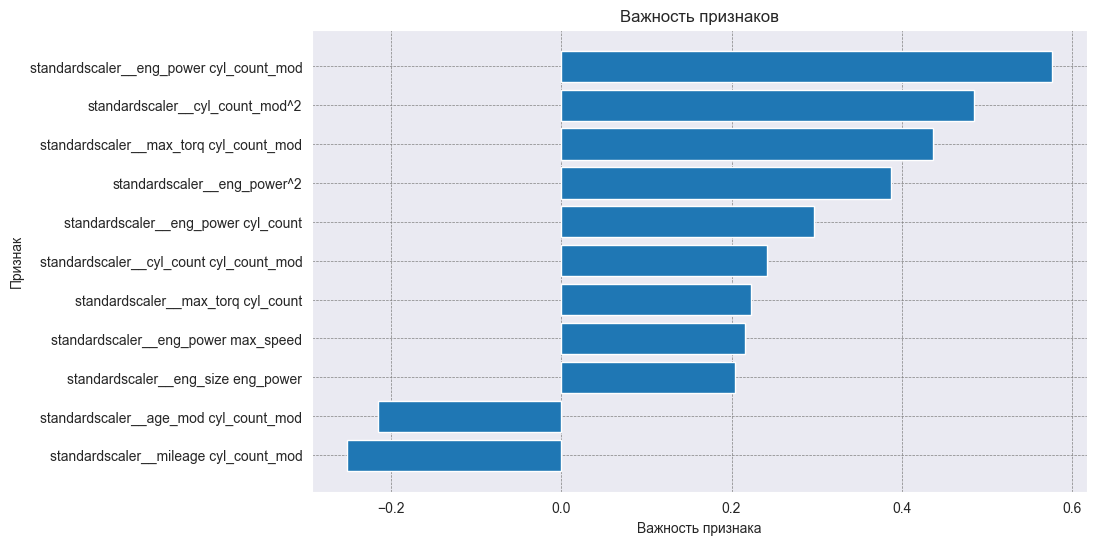

In [83]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl_poly.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl_poly.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.2]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [85]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_poly = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 50)
}
gs_ridge_pl_poly = GridSearchCV(
                           ridge_pl_poly,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_ridge_pl_poly.fit(X_train_poly, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_poly.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_poly.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_poly.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_poly.best_estimator_,
                    'gs_ridge_pl_poly.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.8307725042104721
best_params: {'ridge__alpha': np.float64(1.0)}


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.3446e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [86]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_ridge_pl_poly.best_estimator_.predict(X_train_poly))}')
print(f'MSE {MSE(y_train, gs_ridge_pl_poly.best_estimator_.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_ridge_pl_poly.best_estimator_.predict(X_test_poly))}')
print(f'MSE {MSE(y_test, gs_ridge_pl_poly.best_estimator_.predict(X_test_poly))}')

Обучающая выборка
R2 0.8724137544631958
MSE 3.995415210723877
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 0.855195164680481
MSE 3.0537261962890625


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


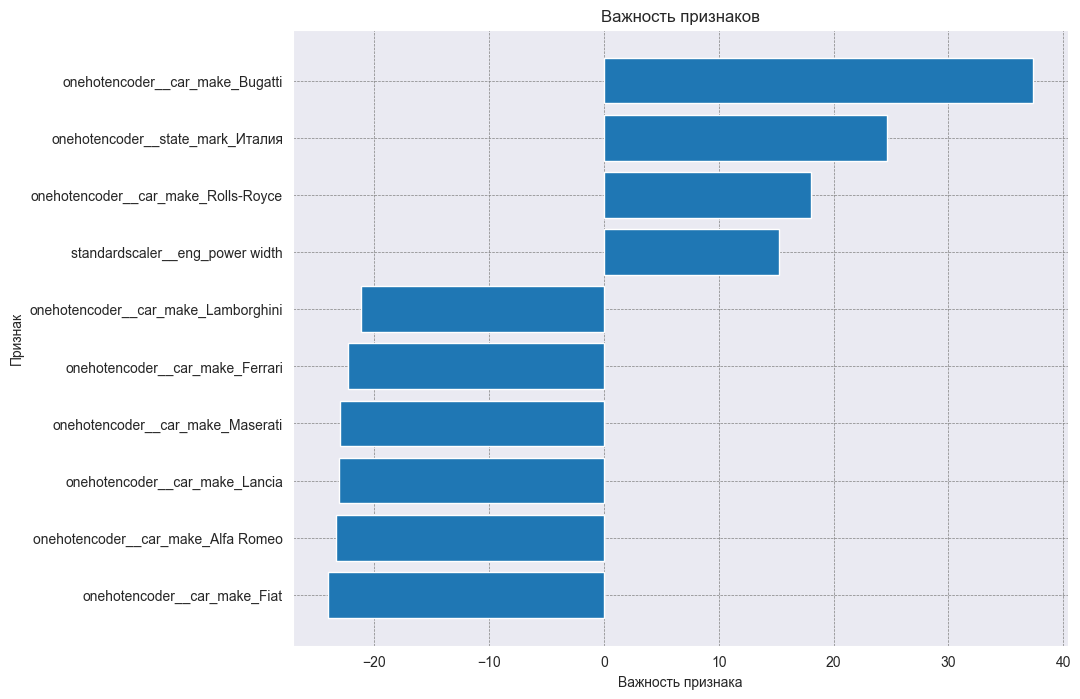

In [87]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_poly.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_poly.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>15]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

## Логарифмируем целевую переменную

In [99]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

### Линейная регрессия

In [104]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl_poly_log = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl_poly_log.fit(X_train_poly, y_train_log)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train_log, lr_pl_poly_log.predict(X_train_poly))}')
print(f'MSE {MSE(y_train_log, lr_pl_poly_log.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test_log, lr_pl_poly_log.predict(X_test_poly))}')
print(f'MSE {MSE(y_test_log, lr_pl_poly_log.predict(X_test_poly))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_pl_poly_log,
                    os.path.join(MODEL_PATH, 'lr_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl_poly_log,
                    'lr_pl_poly_log.pkl',
                    compress=0)

Обучающая выборка
R2 0.9222656488418579
MSE 0.10584351420402527
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 0.9213932156562805
MSE 0.1070733368396759


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


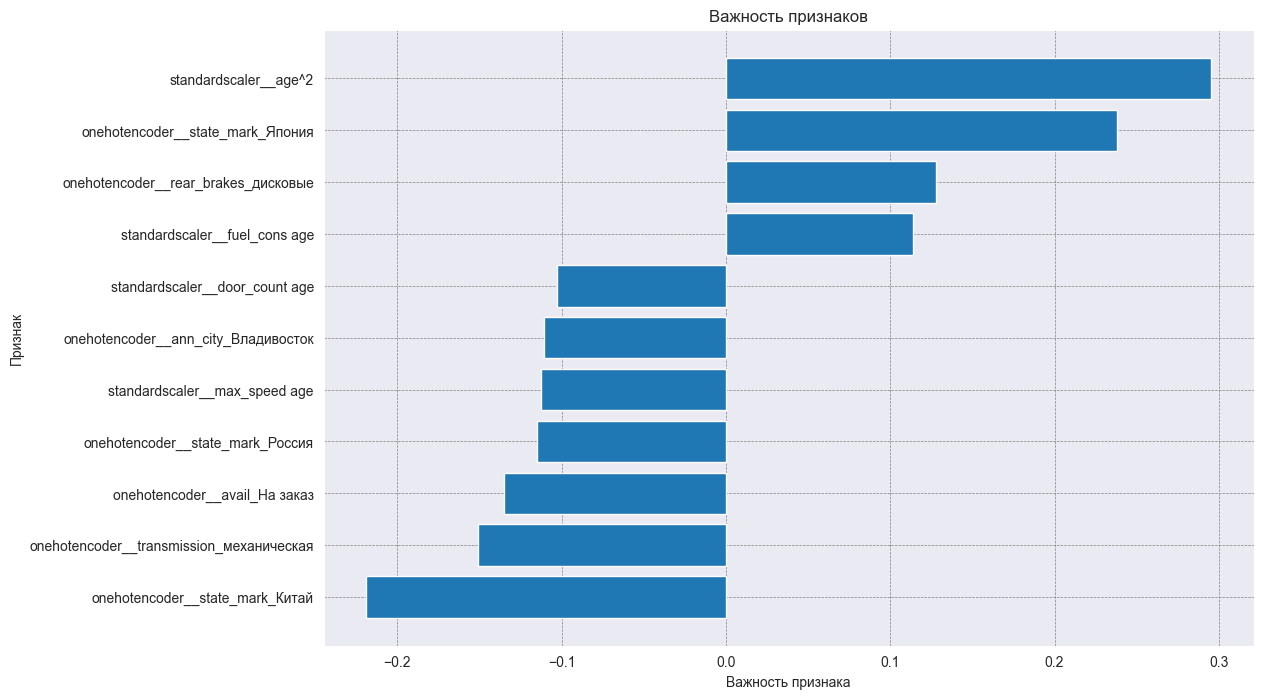

In [105]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl_poly_log.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = lr_pl_poly_log[:-1].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.1]
# Построим диаграмму для наглядности
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [106]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl_poly_log = make_pipeline(col_transformer, Lasso())

param_grid_lasso = {
    'lasso__alpha': np.linspace(1, 50000, 50)
}
gs_lasso_pl_poly_log = GridSearchCV(
                           lasso_pl_poly_log,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_lasso_pl_poly_log.fit(X_train_poly, y_train_log)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl_poly_log.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl_poly_log.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl_poly_log.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl_poly_log.best_estimator_,
                    'gs_lasso_pl_poly_log.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: -7.4803829193115234e-06
best_params: {'lasso__alpha': np.float64(1.0)}


In [107]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train_log, gs_lasso_pl_poly_log.best_estimator_.predict(X_train_poly))}')
print(f'MSE {MSE(y_train_log, gs_lasso_pl_poly_log.best_estimator_.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test_log, gs_lasso_pl_poly_log.best_estimator_.predict(X_test_poly))}')
print(f'MSE {MSE(y_test_log, gs_lasso_pl_poly_log.best_estimator_.predict(X_test_poly))}')

Обучающая выборка
R2 0.0
MSE 1.3616058826446533
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 -0.0002186298370361328
MSE 1.362436294555664


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### ElasticNet

In [113]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl_poly_log = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet_log = {
    'elasticnet__alpha': np.linspace(1, 50000, 20),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 10),
}
gs_elnet_pl_poly_log = GridSearchCV(
                           elnet_pl_poly_log,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_elnet_pl_poly_log.fit(X_train_poly, y_train_log)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_poly_log.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_poly_log.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_poly_log.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_poly_log.best_estimator_,
                    'gs_elnet_pl_poly_log.pkl',
                    compress=0)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
best_score: 0.8625758439302444
best_params: {'elasticnet__alpha': np.float64(1.0), 'elasticnet__l1_ratio': np.float64(0.01)}


In [114]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train_log, gs_elnet_pl_poly_log.best_estimator_.predict(X_train_poly))}')
print(f'MSE {MSE(y_train_log, gs_elnet_pl_poly_log.best_estimator_.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test_log, gs_elnet_pl_poly_log.best_estimator_.predict(X_test_poly))}')
print(f'MSE {MSE(y_test_log, gs_elnet_pl_poly_log.best_estimator_.predict(X_test_poly))}')

Обучающая выборка
R2 0.8627392649650574
MSE 0.18689502775669098
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 0.8614393472671509
MSE 0.1887388378381729


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


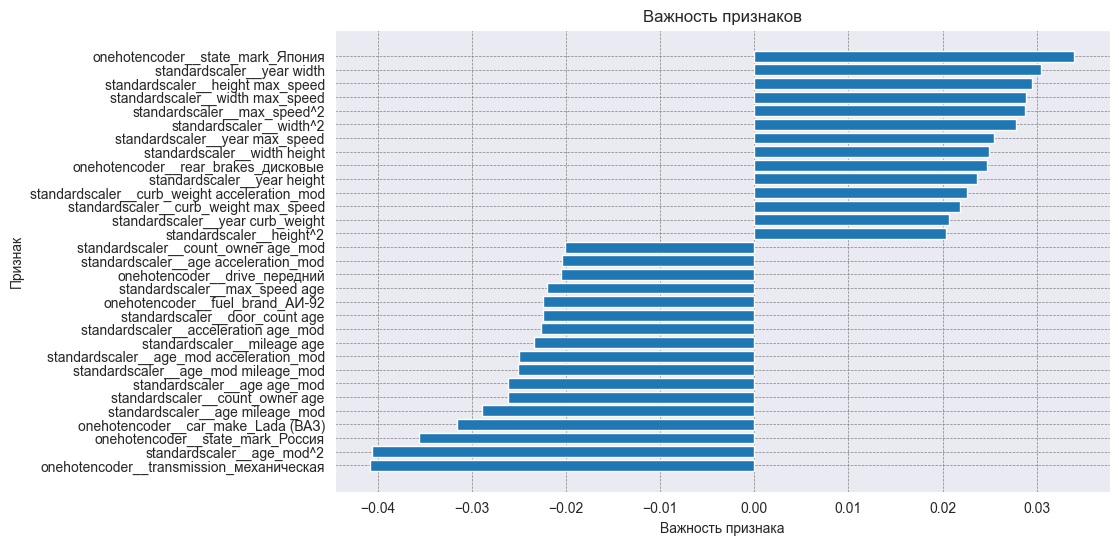

In [117]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl_poly_log.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl_poly_log.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.02]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [119]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_poly_log = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 50)
}
gs_ridge_pl_poly_log = GridSearchCV(
                           ridge_pl_poly_log,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=3
)

gs_ridge_pl_poly_log.fit(X_train_poly, y_train_log)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_poly_log.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_poly_log.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_poly_log.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_poly_log.best_estimator_,
                    'gs_ridge_pl_poly_log.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.9423355162143707
best_params: {'ridge__alpha': np.float64(1.0)}


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.3446e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [120]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train_log, gs_ridge_pl_poly_log.best_estimator_.predict(X_train_poly))}')
print(f'MSE {MSE(y_train_log, gs_ridge_pl_poly_log.best_estimator_.predict(X_train_poly))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test_log, gs_ridge_pl_poly_log.best_estimator_.predict(X_test_poly))}')
print(f'MSE {MSE(y_test_log, gs_ridge_pl_poly_log.best_estimator_.predict(X_test_poly))}')

Обучающая выборка
R2 0.9447020292282104
MSE 0.07529403269290924
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 0.9415772557258606
MSE 0.07957988977432251


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


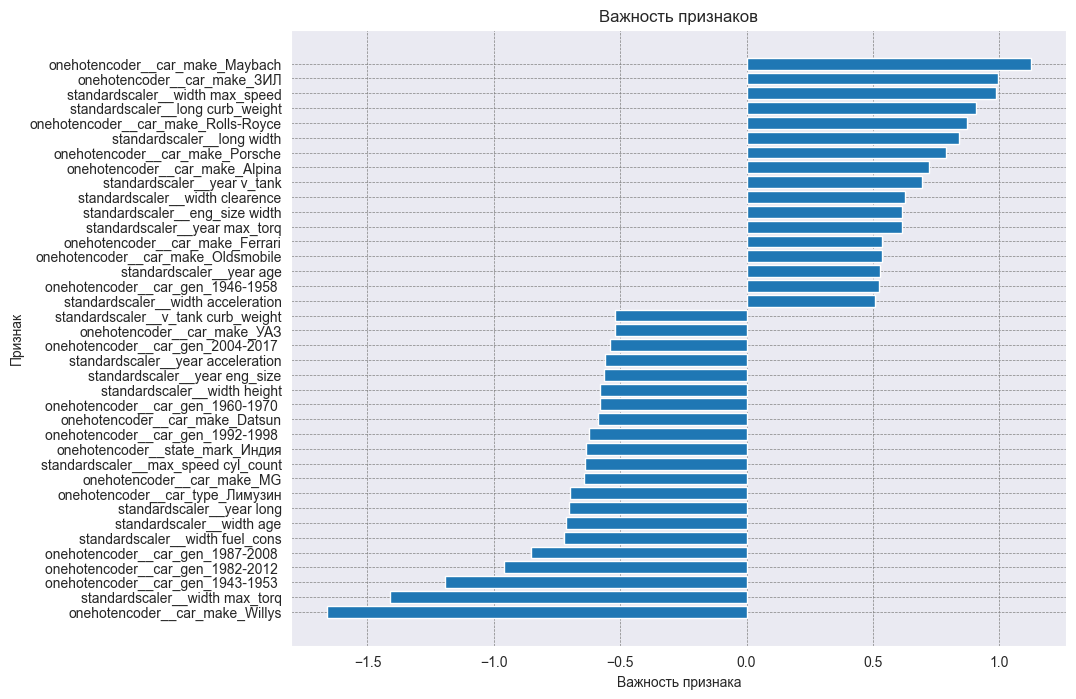

In [124]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_poly_log.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_poly_log.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.5]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

## Бизнес-метрика

Возьмём в качестве метрики долю верно спрогнозированных цен, при этом ошибка недопрогноза и перепрогноза будет учитываться по-разному:
- по недопрогнозов учитываем те прогнозы, которые в пределах отклонения under_est,
- по перепрогнозам - те прогнозы, которые в пределах отклонения over_est.  
Т.е. среди всех предсказанных цен на авто посчитаем долю прогнозов, отличающихся от реальных цен на эти авто не более чем на `under_est`% в сторону уменьшения и не более чем на `over_est`% в сторону увеличения.

In [88]:
def good_prediction_part(y_true, y_pred, under_est=0.05, over_est=0.10):
    deviations = abs(y_pred - y_true) / y_true

    result = (((deviations - 1 <= over_est) & (deviations > 1)).sum() +
              ((1 - deviations >= under_est) & (deviations < 1)).sum()) / len(y_true)

    return result

In [125]:
lr_pl = joblib.load(os.path.join(MODEL_PATH, 'lr_pl.pkl'))
lr_pl_ext = joblib.load(os.path.join(MODEL_PATH, 'lr_pl_ext.pkl'))
lr_pl_poly = joblib.load(os.path.join(MODEL_PATH, 'lr_pl_poly.pkl'))
lr_pl_poly_log = joblib.load(os.path.join(MODEL_PATH, 'lr_pl_poly_log.pkl'))
gs_lasso_pl = joblib.load(os.path.join(MODEL_PATH, 'gs_lasso_pl.pkl'))
gs_lasso_pl_ext = joblib.load(os.path.join(MODEL_PATH, 'gs_lasso_pl_ext.pkl'))
gs_lasso_pl_poly = joblib.load(os.path.join(MODEL_PATH, 'gs_lasso_pl_poly.pkl'))
gs_lasso_pl_poly_log = joblib.load(os.path.join(MODEL_PATH, 'gs_lasso_pl_poly_log.pkl'))
gs_elnet_pl = joblib.load(os.path.join(MODEL_PATH, 'gs_elnet_pl.pkl'))
gs_elnet_pl_ext = joblib.load(os.path.join(MODEL_PATH, 'gs_elnet_pl_ext.pkl'))
gs_elnet_pl_poly = joblib.load(os.path.join(MODEL_PATH, 'gs_elnet_pl_poly.pkl'))
gs_elnet_pl_poly_log = joblib.load(os.path.join(MODEL_PATH, 'gs_elnet_pl_poly_log.pkl'))
gs_ridge_pl = joblib.load(os.path.join(MODEL_PATH, 'gs_ridge_pl.pkl'))
gs_ridge_pl_ext = joblib.load(os.path.join(MODEL_PATH, 'gs_ridge_pl_ext.pkl'))
gs_ridge_pl_poly = joblib.load(os.path.join(MODEL_PATH, 'gs_ridge_pl_poly.pkl'))
gs_ridge_pl_poly_log = joblib.load(os.path.join(MODEL_PATH, 'gs_ridge_pl_poly_log.pkl'))

In [126]:
# Вычислим метрику у обученных моделей
print('Обучающая выборка')
print(f'{"good_prediction_part (LinearRegression numeric)":<50} {good_prediction_part(y_train, lr_pl.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (LinearRegression ext)":<50} {good_prediction_part(y_train, lr_pl_ext.predict(X_train)):.10}')
print(f'{"good_prediction_part (LinearRegression poly)":<50} {good_prediction_part(y_train, lr_pl_poly.predict(X_train_poly)):.10}')
print(f'{"good_prediction_part (LinearRegression poly log)":<50} {good_prediction_part(y_train_log, lr_pl_poly_log.predict(X_train_poly)):.10}')
print(f'{"good_prediction_part (Lasso numeric)":<50} {good_prediction_part(y_train, gs_lasso_pl.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (Lasso ext)":<50} {good_prediction_part(y_train, gs_lasso_pl_ext.predict(X_train)):.10}')
print(f'{"good_prediction_part (Lasso poly)":<50} {good_prediction_part(y_train, gs_lasso_pl_poly.predict(X_train_poly)):.10}')
print(f'{"good_prediction_part (Lasso poly log)":<50} {good_prediction_part(y_train_log, gs_lasso_pl_poly_log.predict(X_train_poly)):.10}')
print(f'{"good_prediction_part (ElasticNet numeric)":<50} {good_prediction_part(y_train, gs_elnet_pl.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (ElasticNet ext)":<50} {good_prediction_part(y_train, gs_elnet_pl_ext.predict(X_train)):.10}')
print(f'{"good_prediction_part (ElasticNet poly)":<50} {good_prediction_part(y_train, gs_elnet_pl_poly.predict(X_train_poly)):.10}')
print(f'{"good_prediction_part (ElasticNet poly log)":<50} {good_prediction_part(y_train_log, gs_elnet_pl_poly_log.predict(X_train_poly)):.10}')
print(f'{"good_prediction_part (Ridge numeric)":<50} {good_prediction_part(y_train, gs_ridge_pl.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (Ridge ext)":<50} {good_prediction_part(y_train, gs_ridge_pl_ext.predict(X_train)):.10}')
print(f'{"good_prediction_part (Ridge poly)":<50} {good_prediction_part(y_train, gs_ridge_pl_poly.predict(X_train_poly)):.10}')
print(f'{"good_prediction_part (Ridge poly log)":<50} {good_prediction_part(y_train_log, gs_ridge_pl_poly_log.predict(X_train_poly)):.10}')
print()
print('Тестовая выборка')
print(f'{"good_prediction_part (LinearRegression numeric)":<50} {good_prediction_part(y_test, lr_pl.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (LinearRegression ext)":<50} {good_prediction_part(y_test, lr_pl_ext.predict(X_test)):.10}')
print(f'{"good_prediction_part (LinearRegression poly)":<50} {good_prediction_part(y_test, lr_pl_poly.predict(X_test_poly)):.10}')
print(f'{"good_prediction_part (LinearRegression poly log)":<50} {good_prediction_part(y_test_log, lr_pl_poly_log.predict(X_test_poly)):.10}')
print(f'{"good_prediction_part (Lasso numeric)":<50} {good_prediction_part(y_test, gs_lasso_pl.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (Lasso ext)":<50} {good_prediction_part(y_test, gs_lasso_pl_ext.predict(X_test)):.10}')
print(f'{"good_prediction_part (Lasso poly)":<50} {good_prediction_part(y_test, gs_lasso_pl_poly.predict(X_test_poly)):.10}')
print(f'{"good_prediction_part (Lasso poly log)":<50} {good_prediction_part(y_test_log, gs_lasso_pl_poly_log.predict(X_test_poly)):.10}')
print(f'{"good_prediction_part (ElasticNet numeric)":<50} {good_prediction_part(y_test, gs_elnet_pl.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (ElasticNet ext)":<50} {good_prediction_part(y_test, gs_elnet_pl_ext.predict(X_test)):.10}')
print(f'{"good_prediction_part (ElasticNet poly)":<50} {good_prediction_part(y_test, gs_elnet_pl_poly.predict(X_test_poly)):.10}')
print(f'{"good_prediction_part (ElasticNet poly log)":<50} {good_prediction_part(y_test_log, gs_elnet_pl_poly_log.predict(X_test_poly)):.10}')
print(f'{"good_prediction_part (Ridge numeric)":<50} {good_prediction_part(y_test, gs_ridge_pl.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (Ridge ext)":<50} {good_prediction_part(y_test, gs_ridge_pl_ext.predict(X_test)):.10}')
print(f'{"good_prediction_part (Ridge poly)":<50} {good_prediction_part(y_test, gs_ridge_pl_poly.predict(X_test_poly)):.10}')
print(f'{"good_prediction_part (Ridge poly log)":<50} {good_prediction_part(y_test_log, gs_ridge_pl_poly_log.predict(X_test_poly)):.10}')

Обучающая выборка
good_prediction_part (LinearRegression numeric)    0.5986986139
good_prediction_part (LinearRegression ext)        0.823099984
good_prediction_part (LinearRegression poly)       0.7268080951
good_prediction_part (LinearRegression poly log)   0.9380354105
good_prediction_part (Lasso numeric)               0.754094484
good_prediction_part (Lasso ext)                   0.7542470498
good_prediction_part (Lasso poly)                  0.6970959105
good_prediction_part (Lasso poly log)              0.561792953
good_prediction_part (ElasticNet numeric)          0.6873164443
good_prediction_part (ElasticNet ext)              0.6928698385
good_prediction_part (ElasticNet poly)             0.8757656895
good_prediction_part (ElasticNet poly log)         0.9055083873
good_prediction_part (Ridge numeric)               0.598912206
good_prediction_part (Ridge ext)                   0.8123669817
good_prediction_part (Ridge poly)                  0.8452830477
good_prediction_part (Ridg

D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (LinearRegression poly)       0.7236139505


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (LinearRegression poly log)   0.936838251
good_prediction_part (Lasso numeric)               0.752051994
good_prediction_part (Lasso ext)                   0.7519299423


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (Lasso poly)                  0.6943215452


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (Lasso poly log)              0.5659536814
good_prediction_part (ElasticNet numeric)          0.6823299667
good_prediction_part (ElasticNet ext)              0.6856253623


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (ElasticNet poly)             0.8753852256


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (ElasticNet poly log)         0.9063253288
good_prediction_part (Ridge numeric)               0.5990296891
good_prediction_part (Ridge ext)                   0.7949531627


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (Ridge poly)                  0.8384340768
good_prediction_part (Ridge poly log)              0.9500808592


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучший результат среди рассмотренных линейных моделей показала регрессия на всех признаках.